In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import kplr
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table

import sys
sys.path.append('comet_project')
import analysis_tools_cython as tools

%matplotlib notebook

In [2]:
kic = kplr.API()
kic.data_root = '../lc'

In [3]:
star = kic.star(3542116)
lcs = star.get_light_curves()

i = np.where(tools.d2q(1176) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
print(i, lcs[i].filename)
_ = lcs[i].open() # force download

12 ../lc/data/lightcurves/003542116/kplr003542116-2012088054726_llc.fits


<IPython.core.display.Javascript object>


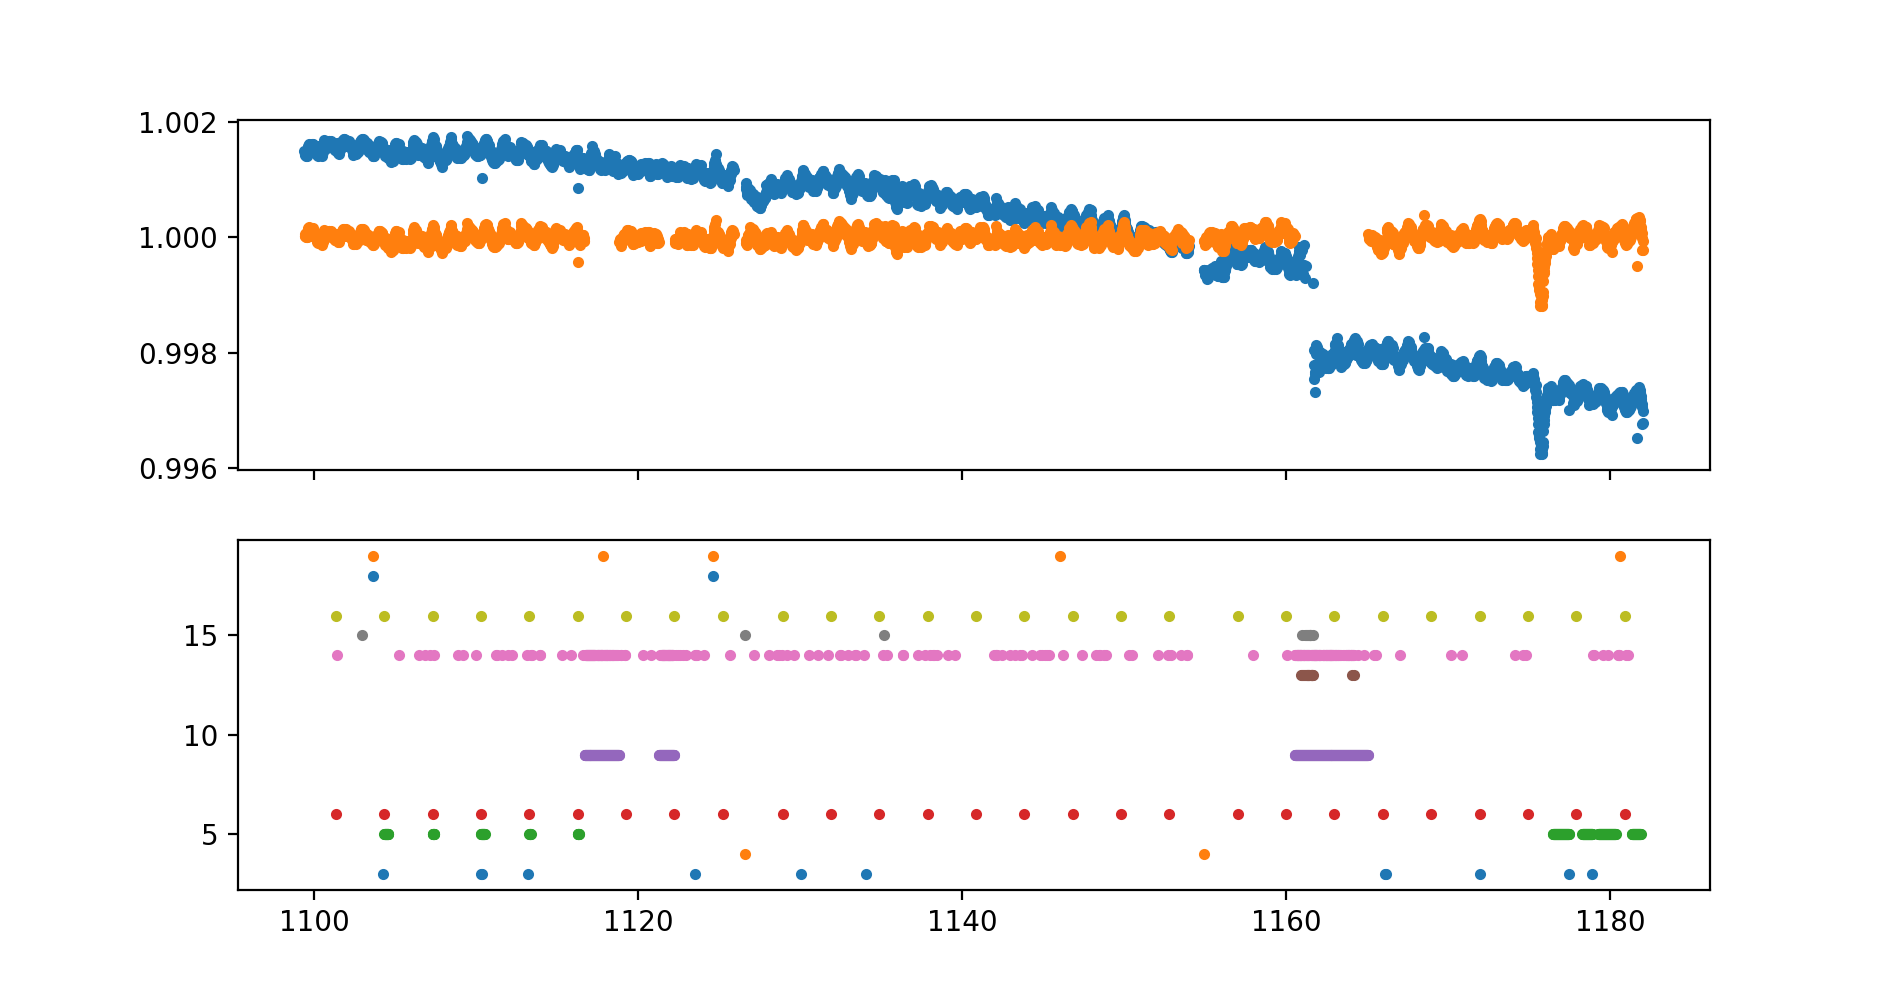

In [4]:
hdulist = fits.open(lcs[i].filename)
scidata = hdulist[1].data
table = Table(scidata)['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_QUALITY']

fig, ax = plt.subplots(2, figsize=(9.5,5), sharex=True)
ax[0].plot(table['TIME'], table['SAP_FLUX']/np.nanmean(table['SAP_FLUX']), '.')
ax[0].plot(table['TIME'], table['PDCSAP_FLUX']/np.nanmean(table['PDCSAP_FLUX']), '.')

q_ind = tools.get_quality_indices(table['SAP_QUALITY'])
for j,ind in enumerate(q_ind):
    if len(ind) > 0:
        ax[1].plot(table['TIME'][ind], np.zeros(len(ind))+j+1, '.')

### plot of before/after lomb-scargle filtering of light curve, including test statistic

In [5]:
def get_lc(file, drop_bad_points=True, keep_interpolated=True, ok_flags=[5]):
    '''get light curve'''
    table = tools.import_lightcurve(file, drop_bad_points=drop_bad_points, ok_flags=ok_flags)
    t,flux,quality,real = tools.clean_data(table)
    if not keep_interpolated:
        t = t[np.array(real,dtype=bool)]
        flux = flux[np.array(real,dtype=bool)]
        quality = quality[np.array(real,dtype=bool)]
        real = real[np.array(real,dtype=bool)]
    timestep = tools.calculate_timestep(table)
    flux = tools.normalise_flux(flux)
    flux_ls = np.copy(flux)
    tools.lombscargle_filter(t,flux_ls,real,0.05)
    flux_ls = flux_ls * real
    return t, timestep, flux, flux_ls, quality, real

t, timestep, flux, flux_ls, quality, real = get_lc(lcs[i].filename, keep_interpolated=False)

In [6]:
def get_stat(flux_ls):
    '''get transit statistic'''
    T = tools.test_statistic_array(flux_ls,60)
    data = tools.nonzero(T)
    m,n = np.unravel_index(T.argmin(),T.shape)
    return T, m, n

T, m, n = get_stat(flux_ls)

minT = T[m,n]
minT_time = t[n]
minT_duration = m*timestep

print(minT)
print(minT_duration)

-37.14221954345703
0.4699754535104148


<IPython.core.display.Javascript object>


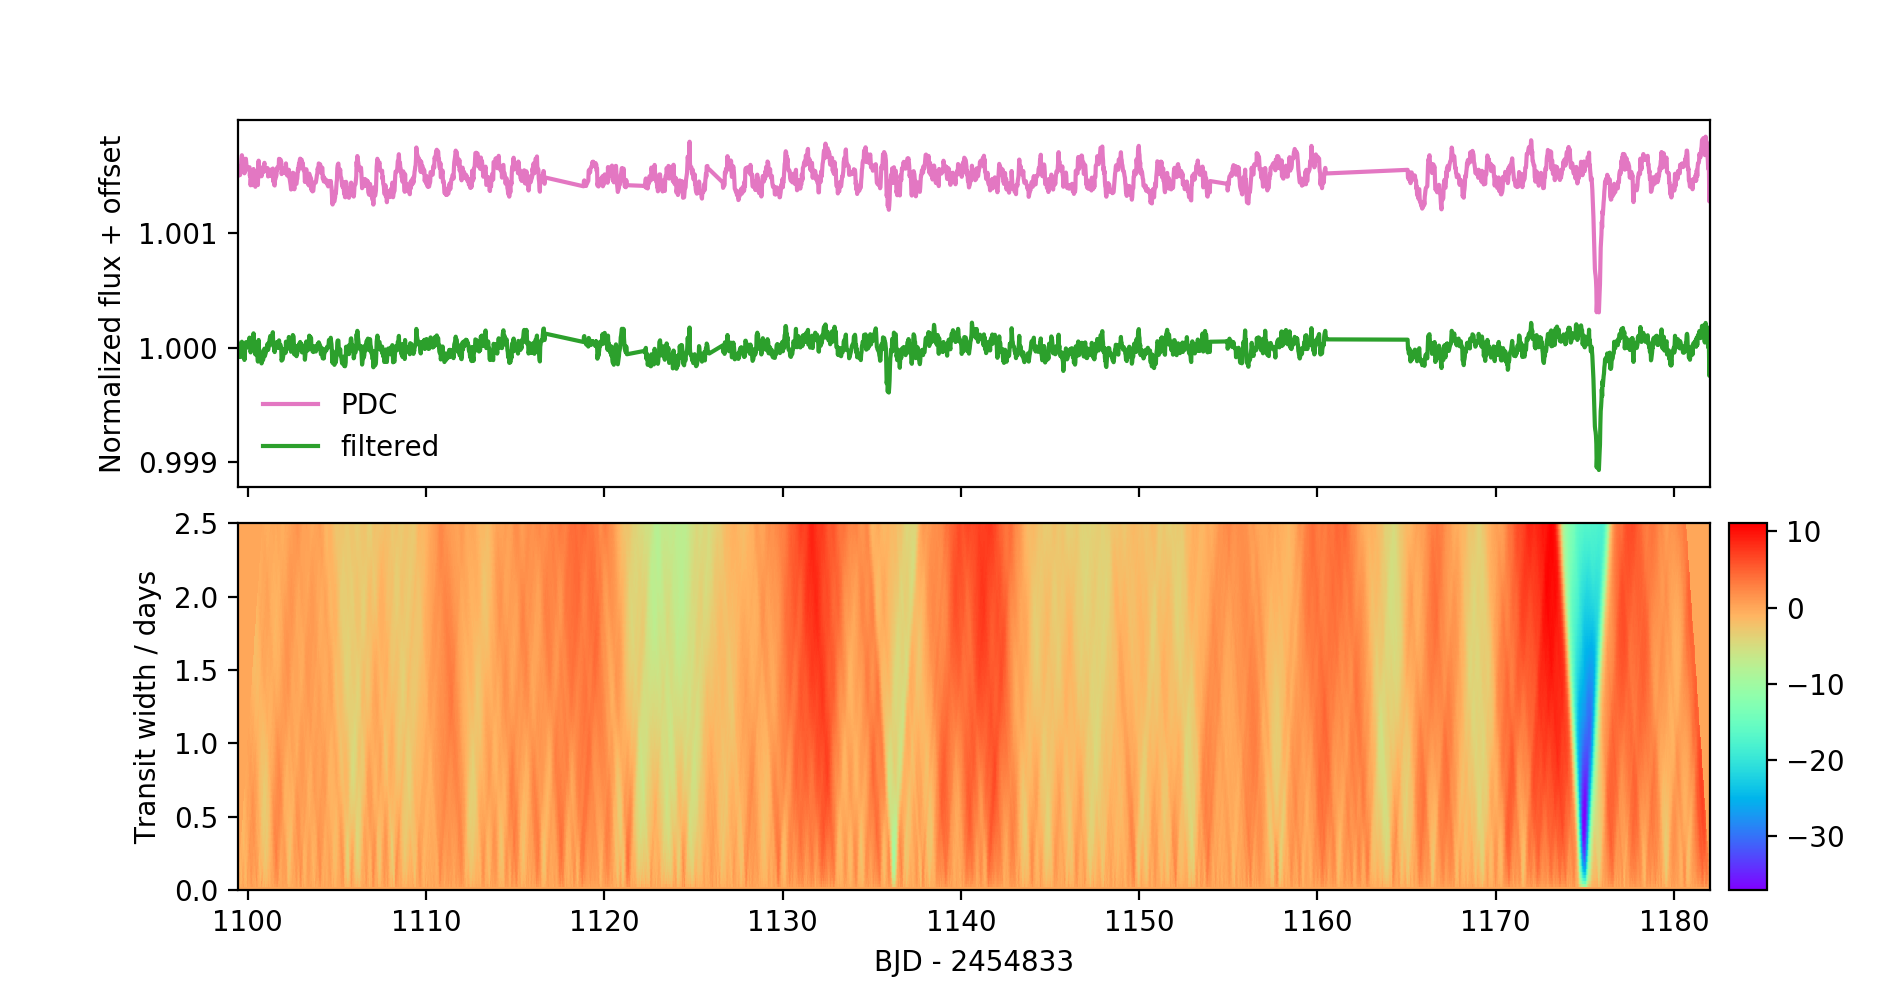

In [7]:
# need to set keep_interpolated to True for T to line up with light curve
fig, ax = plt.subplots(2, figsize=(9.5,5), sharex=True)

ax[0].plot(t, flux+1.0015, '-', color='C6', label='PDC')
ax[0].plot(t, flux_ls+1, '-', color='C2', label='filtered')
ax[0].set_xlim(np.min(t), np.max(t))
ax[0].legend(loc=3, frameon=False)
# ax[0].set_ylim(0.9985, 1.0021)

im = ax[1].imshow(T, origin='bottom', extent=ax[0].get_xlim()+(0,2.5), aspect='auto',
                  cmap='rainbow')
ax[1].set_ylim(0,2.5)

ax[0].set_ylabel('Normalized flux + offset')
ax[1].set_xlabel('BJD - 2454833')
ax[1].set_ylabel('Transit width / days')

fig.subplots_adjust(hspace=0.1)

cax = fig.add_axes([.91, ax[1].get_position().min[1], 0.02, ax[1].get_position().height])

fig.colorbar(im, cax=cax)

pos = ax[0].get_position()
pos2 = ax[1].get_position()
ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])

fig.savefig('figs/periodics.pdf')

<IPython.core.display.Javascript object>


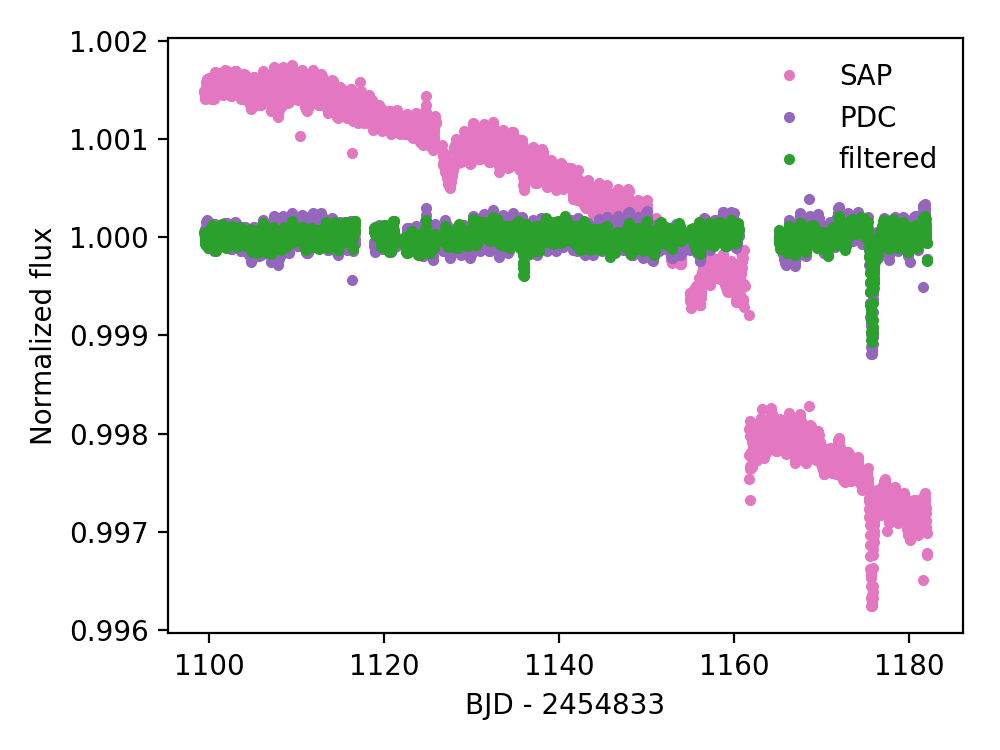

In [8]:
# a nice version
fig, ax = plt.subplots(figsize=(5,3.75))
ax.plot(table['TIME'], table['SAP_FLUX']/np.nanmean(table['SAP_FLUX']), '.', color='C6', label='SAP')
ax.plot(table['TIME'], table['PDCSAP_FLUX']/np.nanmean(table['PDCSAP_FLUX']), '.', color='C4', label='PDC')
ax.plot(t, flux_ls+1, '.', color='C2', label='filtered')

ax.legend(frameon=False)
# ax.set_xlim(375,392)
# ax.set_ylim(0.997,1.004)
ax.set_ylabel('Normalized flux')
ax.set_xlabel('BJD - 2454833')

fig.tight_layout()
fig.savefig('figs/lc-before-after.pdf')

<IPython.core.display.Javascript object>


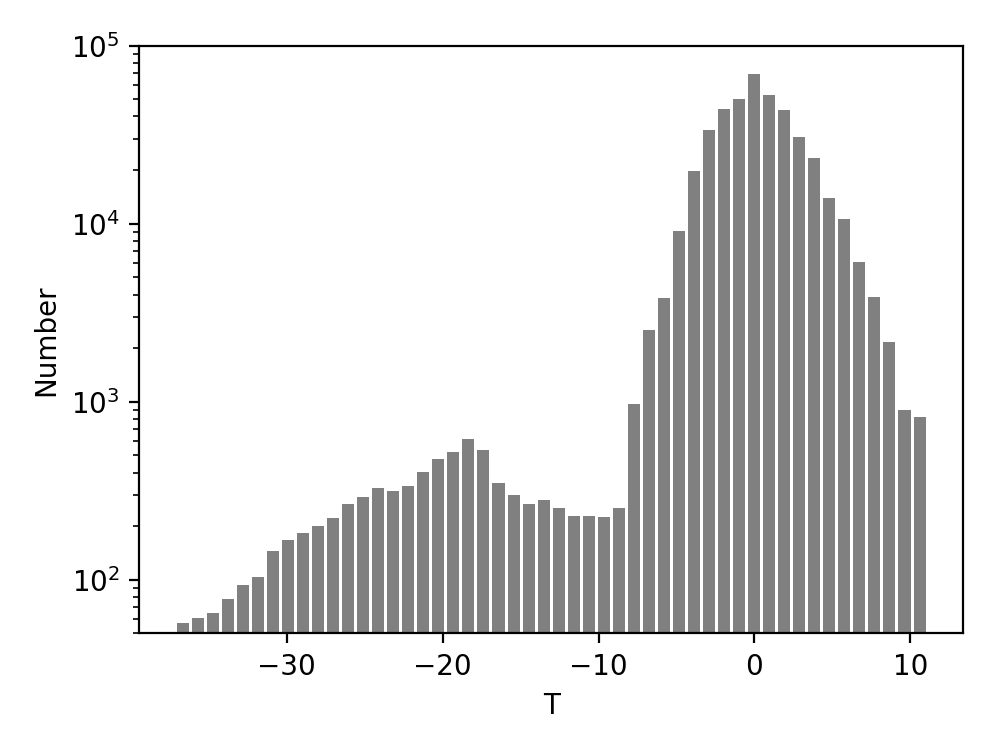

[5.90177967e+04 5.83650016e-02 2.68622130e+00]
4.072169834352778


In [9]:
fig, ax = plt.subplots(figsize=(5,3.75))

bottom = 50
hist, bins = np.histogram(T, bins=50, normed=False)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist-bottom, align='center', width=width, bottom=bottom,
       color='grey')#, edgecolor=np.repeat('grey', len(bins)))
ylim = ax.get_ylim()

p = tools.single_gaussian_curve_fit(center, hist)
print(p)
print(np.std(T))
# ax.plot(center, tools.gauss(center, p[0], p[1], np.std(T)), color='black', alpha=0.5, linewidth=2)

# ax.set_ylim(ylim[0],ylim[1]*1.2)
ax.set_yscale('log')
ax.set_xlabel('T')
ax.set_ylabel('Number')

fig.tight_layout()
fig.savefig('figs/T_hist.pdf')

### fits to a dip

In [10]:
def curve_fit(m, n, t, flux_ls, real, verb=False, cutout_half_width=5, n_m_bg_start=3, n_m_bg_end=1):
    '''get fit results'''
    asym, width1, width2 = tools.calc_shape(m,n,t,flux_ls) # uses updated defaults
    if asym == -3 or asym == -2:
        return np.repeat(None,5)
    w = cutout_half_width
    t2 = t[n-w*m:n+w*m]
    if (t2[-1]-t2[0]) / np.median(np.diff(t2)) / len(t2) > 1.5:
        print('gap in wide')
    t3 = t[int(n-m/2.):int(n+m/2.)]
    if (t3[-1]-t3[0]) / np.median(np.diff(t3)) / m > 1.5:
        print('gap near dip')
    x2 = flux_ls[n-w*m:n+w*m]
    background_level = (sum(x2[:m]) + sum(x2[(2*w-1)*m:]))/(2*m)
    bg_l1 = np.mean(x2[:n_m_bg_start*m])
    bg_t1 = np.mean(t2[:n_m_bg_start*m])
    bg_l2 = np.mean(x2[(2*w-n_m_bg_end)*m:])
    bg_t2 = np.mean(t2[(2*w-n_m_bg_end)*m:])
    grad = (bg_l2-bg_l1)/(bg_t2-bg_t1)
    background_level = bg_l1 + grad * (t2 - bg_t1)
    x2 -= background_level

    paramsgauss = tools.single_gaussian_curve_fit(t2,-x2)
    y2 = -tools.gauss(t2,*paramsgauss)
    paramscomet = tools.comet_curve_fit(t2,-x2)
    w2 = -tools.comet_curve(t2,*paramscomet)
    scores = [tools.score_fit(x2,fit) for fit in [y2, w2]]
    if verb:
        print("Asym score:",round(scores[0]/scores[1],4))
        print('Asym score:',asym)
        print(tools.classify(m, n, real, asym))
        
    return t2, x2, y2, w2, asym

t2, x2, y2, w2, asym = curve_fit(m, n, t, flux_ls, real, verb=True)

Asym score: 1.4968
Asym score: 1.496783624132965
maybeTransit


<IPython.core.display.Javascript object>


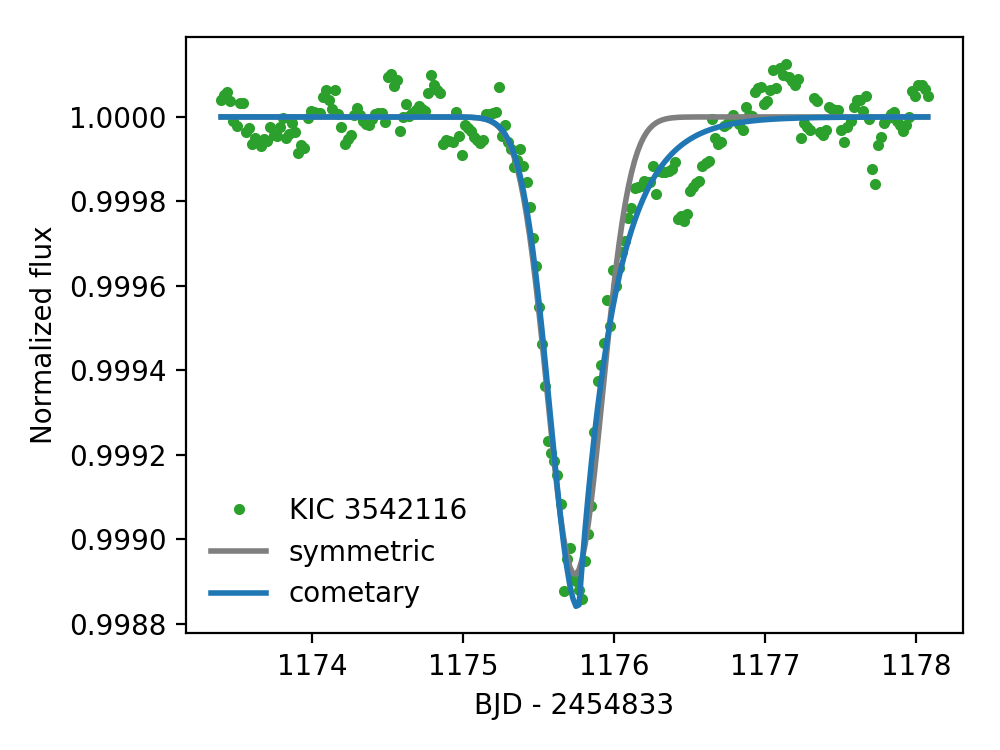

In [11]:
def show_fit(t2, x2, y2, w2, file=None, width=None, name=None, ylim=None):
    '''show fit'''
    fig, ax = plt.subplots(figsize=(5,3.75))

    ax.plot(t2, x2+1, '.', label='KIC {}'.format(name), color='C2')
#     ax.plot(t2, x2-w2+1, '.', label='KIC {}'.format(name), color='C2')
    ax.plot(t2, y2+1.0000, linewidth=2, label='symmetric', color='C7')
    ax.plot(t2, w2+1, linewidth=2, label='cometary', color='C0')
    ax.legend(frameon=False)

    ax.set_ylabel('Normalized flux')
    ax.set_xlabel('BJD - 2454833')

    if width is not None:
        mid = (t2[-1]+t2[0])/2.
        ax.set_xlim(mid-width/2,mid+width/2)
        
    if ylim is not None:
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    if file:
        fig.savefig(file)
        
show_fit(t2, x2, y2, w2, name=star.kepid, width=None, file='figs/modelfits.pdf')

### other light curves

In [12]:
# take a closer look
def fit_one(kic_no, day, drop_bad_points=True, width=None, file=None, ylim=None):
    '''do everything'''
    star = kic.star(kic_no)
    lcs = star.get_light_curves()
    i = np.where(tools.d2q(day) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
    _ = lcs[i].open() # force download
    t, timestep, flux, flux_ls, quality, real = get_lc(lcs[i].filename,
                                                       drop_bad_points=drop_bad_points,
                                                       keep_interpolated=False)
    T, m, n = get_stat(flux_ls)
#     flux_ls -= gp_detrend(m, n, t, flux_ls)
    t2, x2, y2, w2, asym = curve_fit(m, n, t, flux_ls, real, verb=True)
    if t2 is not None:
        show_fit(t2, x2, y2, w2, width=width, name=kic_no, file=file, ylim=ylim)
    else:
        print('fit failed')

In [13]:
# the ones we know about
kic_r18 = [3542116, 11084727]

# those marked as artefacts
artefacts = Table.read('artefact_list.txt', format='ascii.csv', comment='#')
kic_artefacts = list(artefacts['koi'])

In [14]:
# select a subset
data = Table.read('all_snr_gt_5_ok.txt', format='ascii') # list of s/n>5 maybeTransits satisfying width criteria

len(data)

7217

<IPython.core.display.Javascript object>


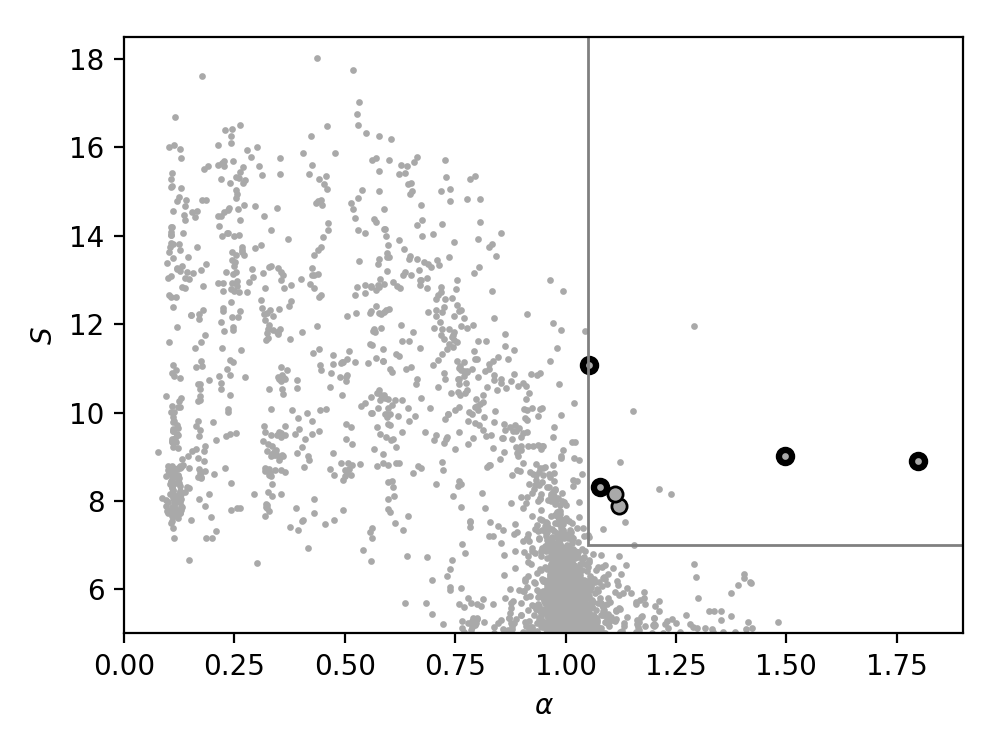

In [15]:
# candidates
fig, ax = plt.subplots(figsize=(5,3.75))

rect = matplotlib.patches.Rectangle((1.05,7),3,20, linewidth=1,edgecolor='grey',facecolor='none')
ax.add_patch(rect)
# rect = matplotlib.patches.Rectangle((1.2,5),3,20,linewidth=1,edgecolor='grey',facecolor='none')
# ax.add_patch(rect)

# ax.scatter(t['alpha'], t['snr'], c='black')
for j,f in enumerate(data['col1']):
    kic_no = int(f.split('-')[0].split('kplr')[1])
    if kic_no not in kic_artefacts and data[j]['col5'] > 1.05 and data[j]['col3'] < -7:
        ax.scatter(data[j]['col5'], -data[j]['col3'], s=30, c='darkgrey', edgecolors='black')
    if kic_no in kic_r18:
        if data[j]['col5'] > 1.05:
            ax.scatter(data[j]['col5'], -data[j]['col3'], c='black')
#             ax.text(data[j]['col5'], -data[j]['col3'], f.split('-')[0].split('kplr')[1]+','+str(data[j]['col4']))
            
ax.scatter(data['col5'], -data['col3'], s=2, c='darkgrey')

ax.set_xlim(0,1.9)
ax.set_ylim(5,18.5)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$S$')

fig.tight_layout()
fig.savefig('figs/asym_snr.pdf')

<IPython.core.display.Javascript object>


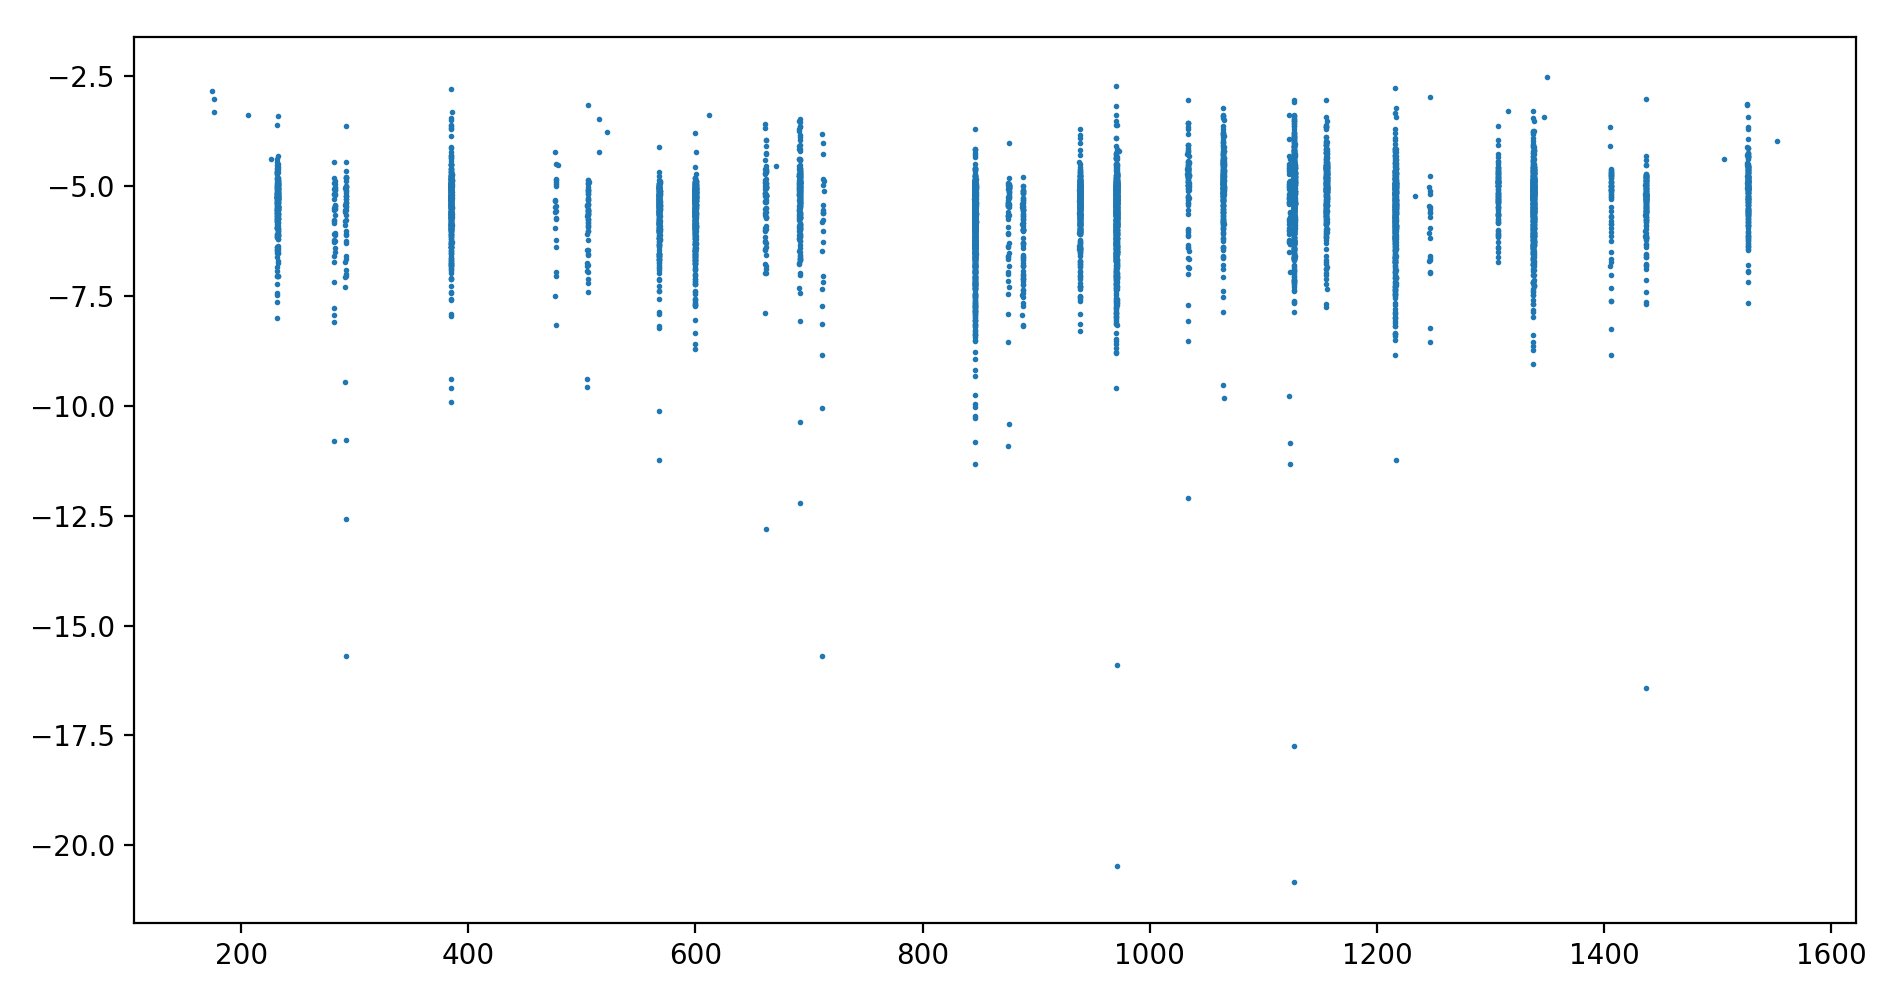

In [16]:
# check gapJustBefore tend to be at specific times
data1 = Table.read('all_snr_gt_5.txt', format='ascii') # list of s/n>5 maybeTransits satisfying width criteria
ok = data1['col10'] == 'gapJustBefore'
fig, ax = plt.subplots(figsize=(9.5,5))
ax.scatter(data1['col4'][ok], data1['col3'][ok], s=1)
# ax.scatter(t['day'], -t['snr'], c='black')
fig.tight_layout()

in region:16
                col1                     col2         col3        col4        col5      col6       col7       col8       col9       col10    
------------------------------------ ------------ ----------- ------------ --------- ---------- ---------- ---------- ---------- ------------
kplr004054905-2010078095331_llc.fits -46.10757446 -8.87541694 395.22488737 1.1234713 0.23157341 0.57612845 1.08298994 -0.0209167 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------ ---------- ---------- ---------- ---------- ----------- ------------
kplr004055609-2010174085026_llc.fits -34.37948608 -7.35711584 488.30299149 1.08499623 0.20060077 0.58707276 0.89911825 -0.00128943 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6      col7       c

<IPython.core.display.Javascript object>


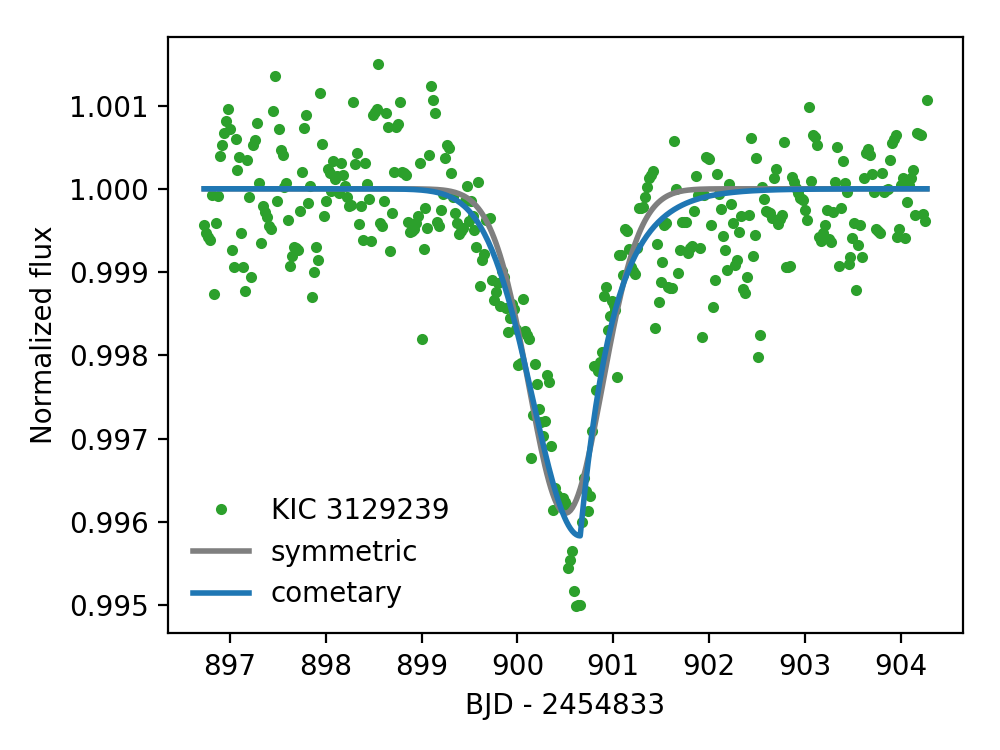

                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr007584900-2012004120508_llc.fits -25.64368629 -7.00965787 1008.27768935 1.15585955 0.45191821 0.15159553 0.49038866 -0.00175929 maybeTransit
artefact
                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr003542116-2012088054726_llc.fits -37.14221954 -9.00654444 1175.74814394 1.49678362 0.18830554 0.23797068 0.46997545 -0.00076315 maybeTransit
Asym score: 1.4968
Asym score: 1.496783624132965
maybeTransit


<IPython.core.display.Javascript object>


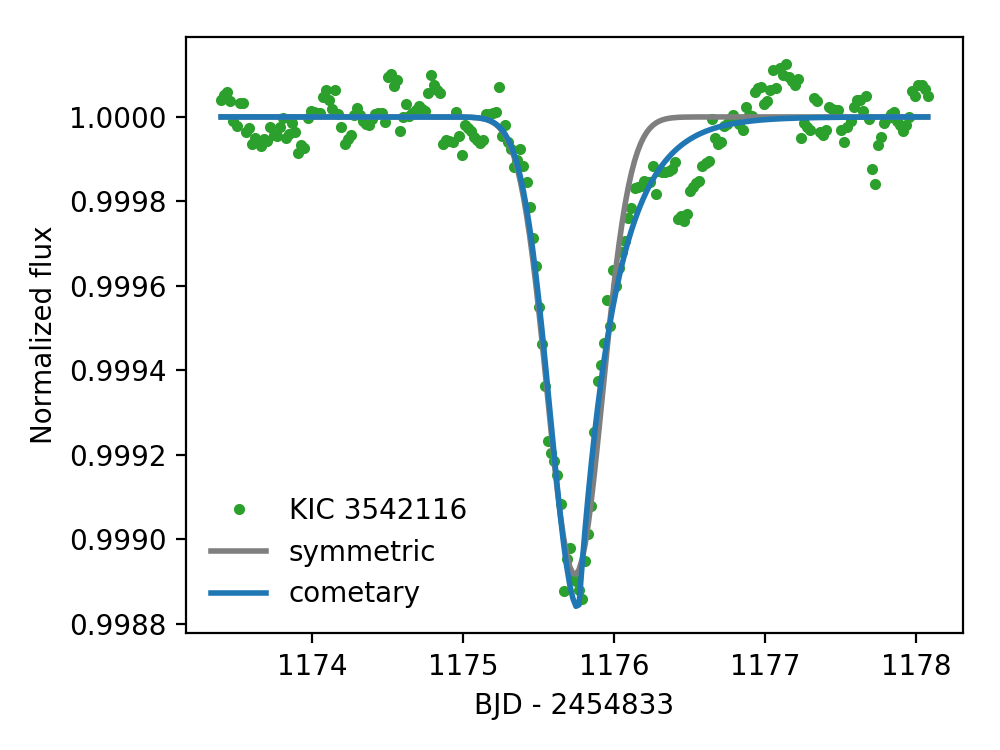

                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr011084727-2012004120508_llc.fits -38.30063629 -8.89771187 1076.07456386 1.79911672 0.12479382 0.33590656 0.40865912 -0.00096458 maybeTransit
Asym score: 1.7991
Asym score: 1.7991167200370772
maybeTransit


<IPython.core.display.Javascript object>


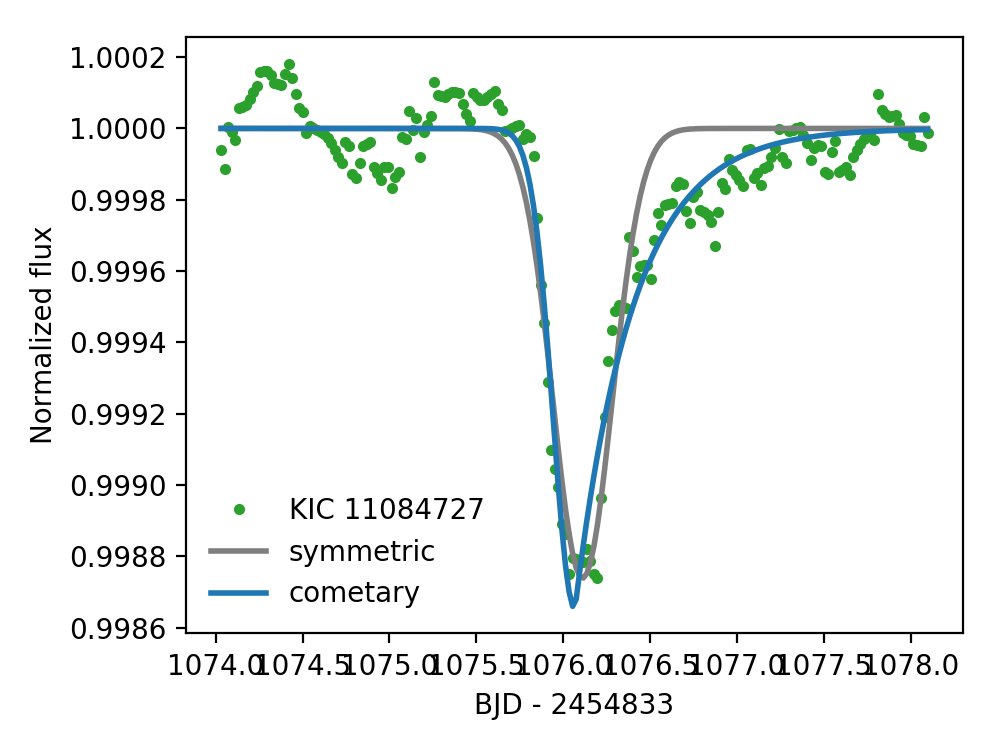

                col1                     col2       col3        col4        col5       col6      col7       col8        col9       col10    
------------------------------------ ----------- ---------- ------------ ---------- --------- ---------- ---------- ----------- ------------
kplr003542116-2011271113734_llc.fits -38.8303566 -8.3169875 991.85041874 1.07852255 0.2846358 0.25323462 0.61300998 -0.00074351 maybeTransit
Asym score: 1.0785
Asym score: 1.0785225536254357
maybeTransit


<IPython.core.display.Javascript object>


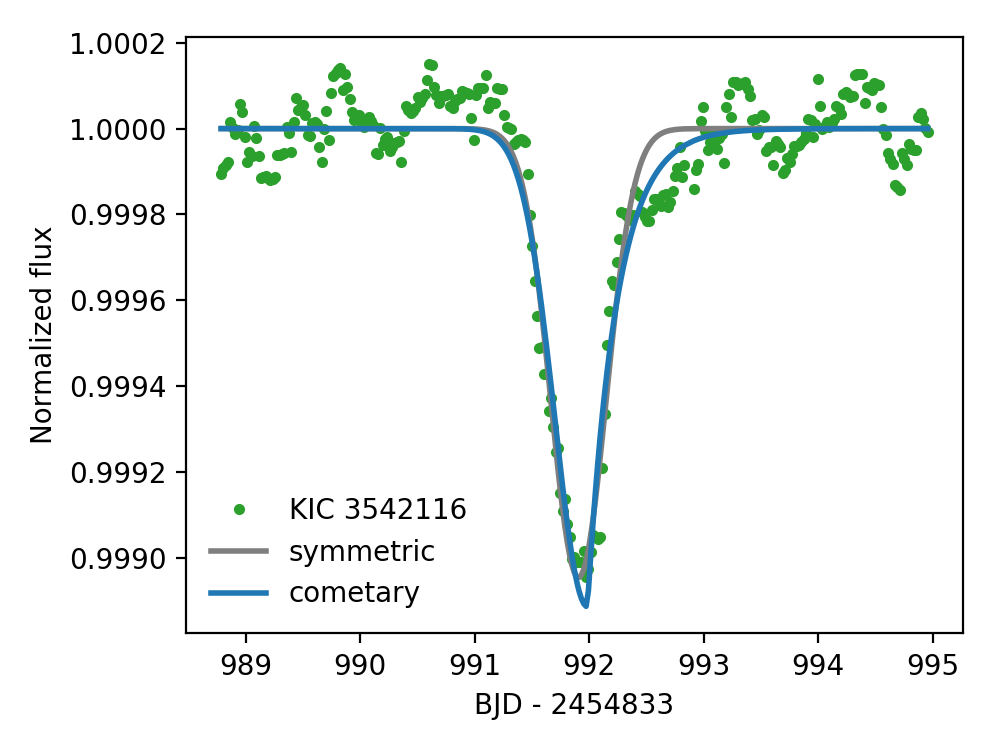

                col1                     col2         col3         col4        col5       col6      col7       col8        col9       col10    
------------------------------------ ------------ ------------ ------------ ---------- --------- ---------- ---------- ----------- ------------
kplr003542116-2012179063303_llc.fits -45.53715897 -11.06552227 1268.1733953 1.05270726 0.2423104 0.22613767 0.51086371 -0.00103507 maybeTransit
Asym score: 1.0527
Asym score: 1.0527072568795441
maybeTransit


<IPython.core.display.Javascript object>


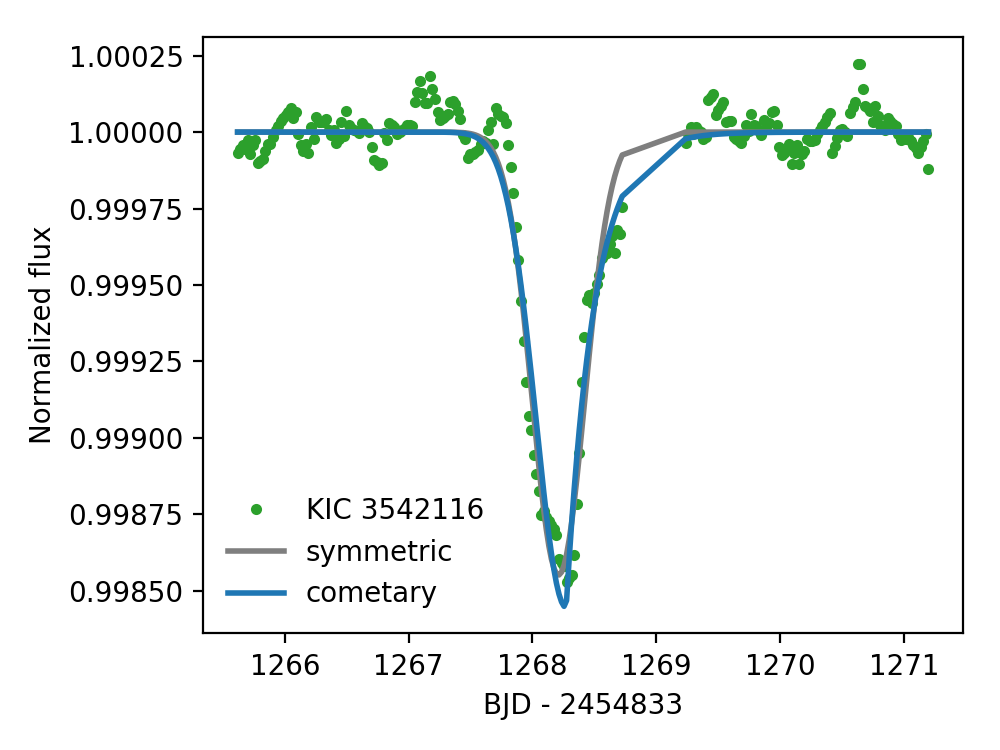

                col1                     col2         col3         col4        col5       col6       col7       col8       col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- --------- ----------- ------------
kplr005622759-2013011073258_llc.fits -28.70291138 -7.17676774 1429.69880446 1.05393392 0.31543258 0.71864837 1.1238039 -0.00060736 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------ ---------- ---------- ---------- ---------- ----------- ------------
kplr008027456-2013011073258_llc.fits -25.68018913 -8.16443912 1448.9464936 1.11091925 0.23821708 0.49723678 0.85817934 -0.00035172 maybeTransit
Asym score: 1.1109
Asym score: 1.110919250494188
maybeTransit


<IPython.core.display.Javascript object>


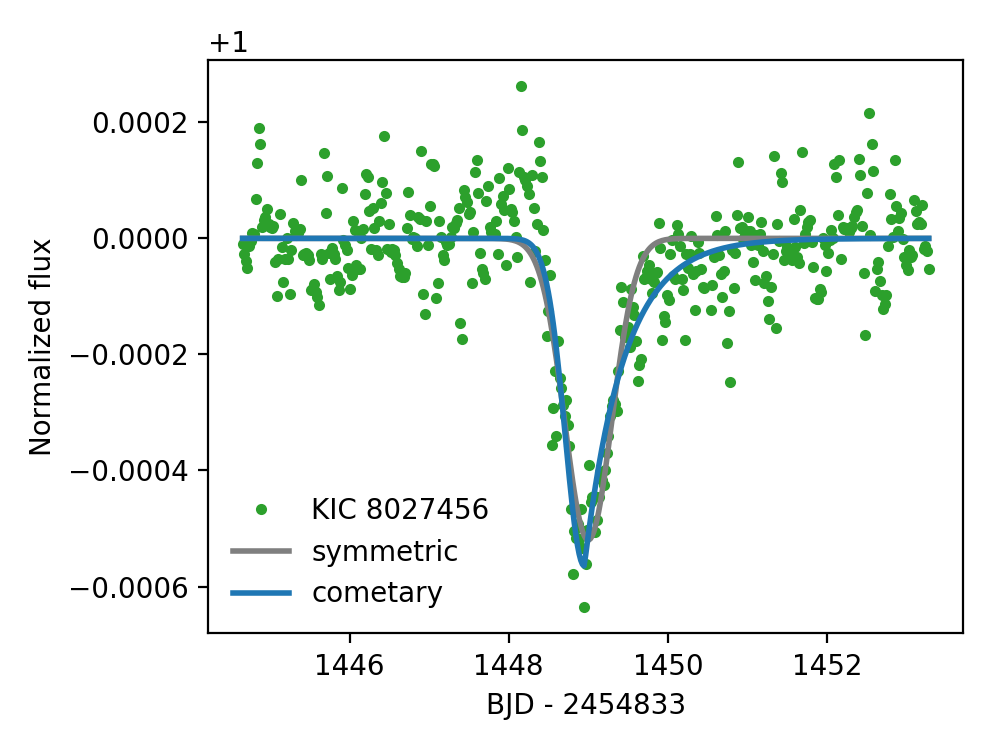

In [17]:
ok = (data['col5'] > 1.05) & (data['col3'] < -7)
# ok = (data['col3'] > -5.1) & (data['col3'] < -5)
print('in region:{}'.format(np.sum(ok)))
keep = []
for i,row in enumerate(data[ok]):
    print(row)
    kic_no = int(row['col1'].split('-')[0].split('kplr')[1])
    if kic_no in kic_artefacts:
        print('artefact')
    else:
        fit_one(kic_no, row['col4'], drop_bad_points=True, #width=8, ylim=(0.9982, 1.00035),
                file='figs/kic{}-{:04.0f}.pdf'.format(kic_no,row['col4']))
        keep.append(i)

In [18]:
t_paper = data[ok][keep]
t_paper.keep_columns(['col1','col3','col4','col5','col6','col7','col9'])
ascii.write(t_paper, format='latex')

\begin{table}
\begin{tabular}{ccccccc}
col1 & col3 & col4 & col5 & col6 & col7 & col9 \\
kplr003129239-2011177032512_llc.fits & -7.88731095 & 900.51169704 & 1.12033999 & 0.49436743 & 0.34779189 & -0.00288337 \\
kplr003542116-2012088054726_llc.fits & -9.00654444 & 1175.74814394 & 1.49678362 & 0.18830554 & 0.23797068 & -0.00076315 \\
kplr011084727-2012004120508_llc.fits & -8.89771187 & 1076.07456386 & 1.79911672 & 0.12479382 & 0.33590656 & -0.00096458 \\
kplr003542116-2011271113734_llc.fits & -8.3169875 & 991.85041874 & 1.07852255 & 0.2846358 & 0.25323462 & -0.00074351 \\
kplr003542116-2012179063303_llc.fits & -11.06552227 & 1268.1733953 & 1.05270726 & 0.2423104 & 0.22613767 & -0.00103507 \\
kplr008027456-2013011073258_llc.fits & -8.16443912 & 1448.9464936 & 1.11091925 & 0.23821708 & 0.49723678 & -0.00035172 \\
\end{tabular}
\end{table}


                col1                     col2         col3        col4        col5      col6       col7       col8       col9       col10    
------------------------------------ ------------ ----------- ------------ --------- ---------- ---------- ---------- ---------- ------------
kplr004054905-2010078095331_llc.fits -46.10757446 -8.87541694 395.22488737 1.1234713 0.23157341 0.57612845 1.08298994 -0.0209167 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------ ---------- ---------- ---------- ---------- ----------- ------------
kplr004055609-2010174085026_llc.fits -34.37948608 -7.35711584 488.30299149 1.08499623 0.20060077 0.58707276 0.89911825 -0.00128943 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6      col7       col8        co

<IPython.core.display.Javascript object>


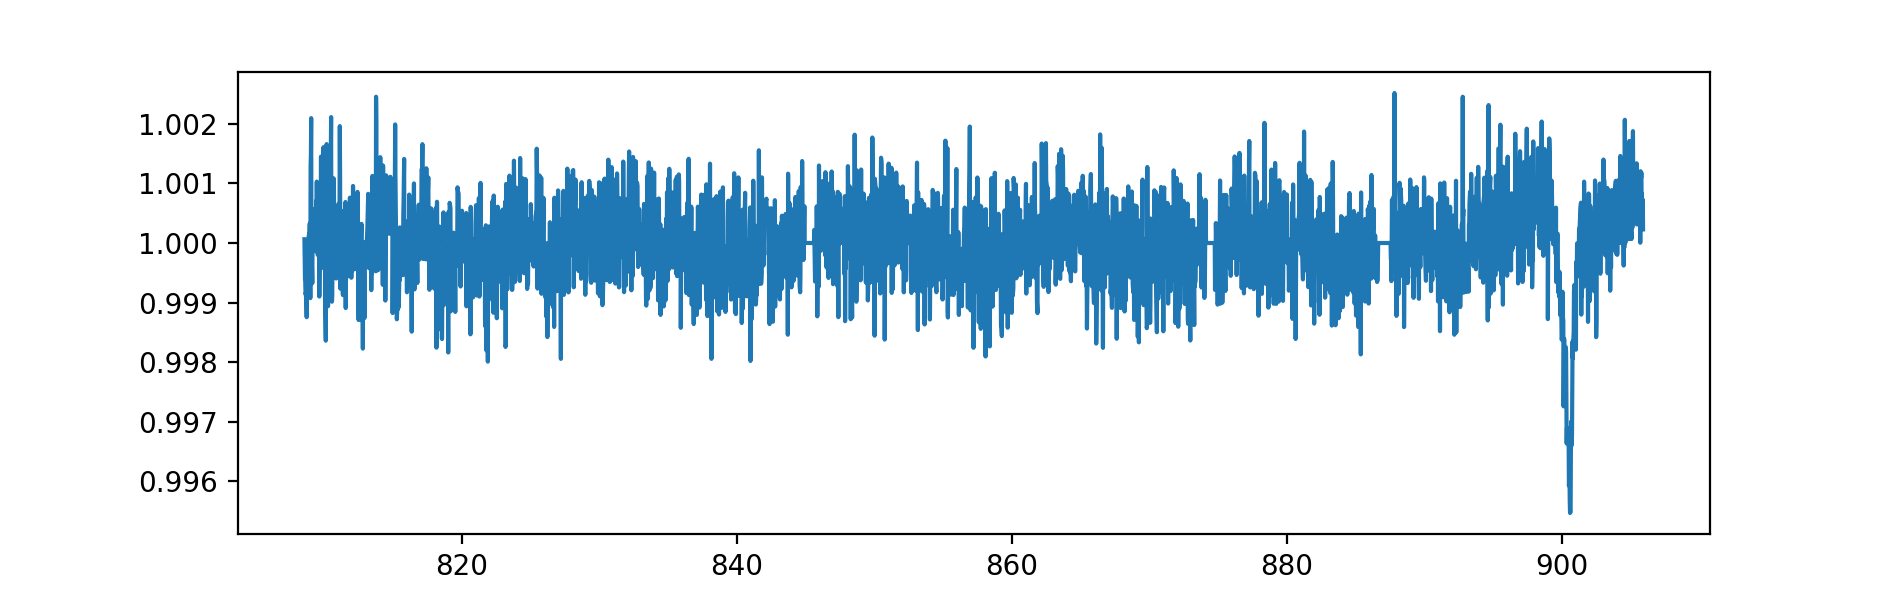

                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr007584900-2012004120508_llc.fits -25.64368629 -7.00965787 1008.27768935 1.15585955 0.45191821 0.15159553 0.49038866 -0.00175929 maybeTransit
artefact
                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr003542116-2012088054726_llc.fits -37.14221954 -9.00654444 1175.74814394 1.49678362 0.18830554 0.23797068 0.46997545 -0.00076315 maybeTransit


<IPython.core.display.Javascript object>


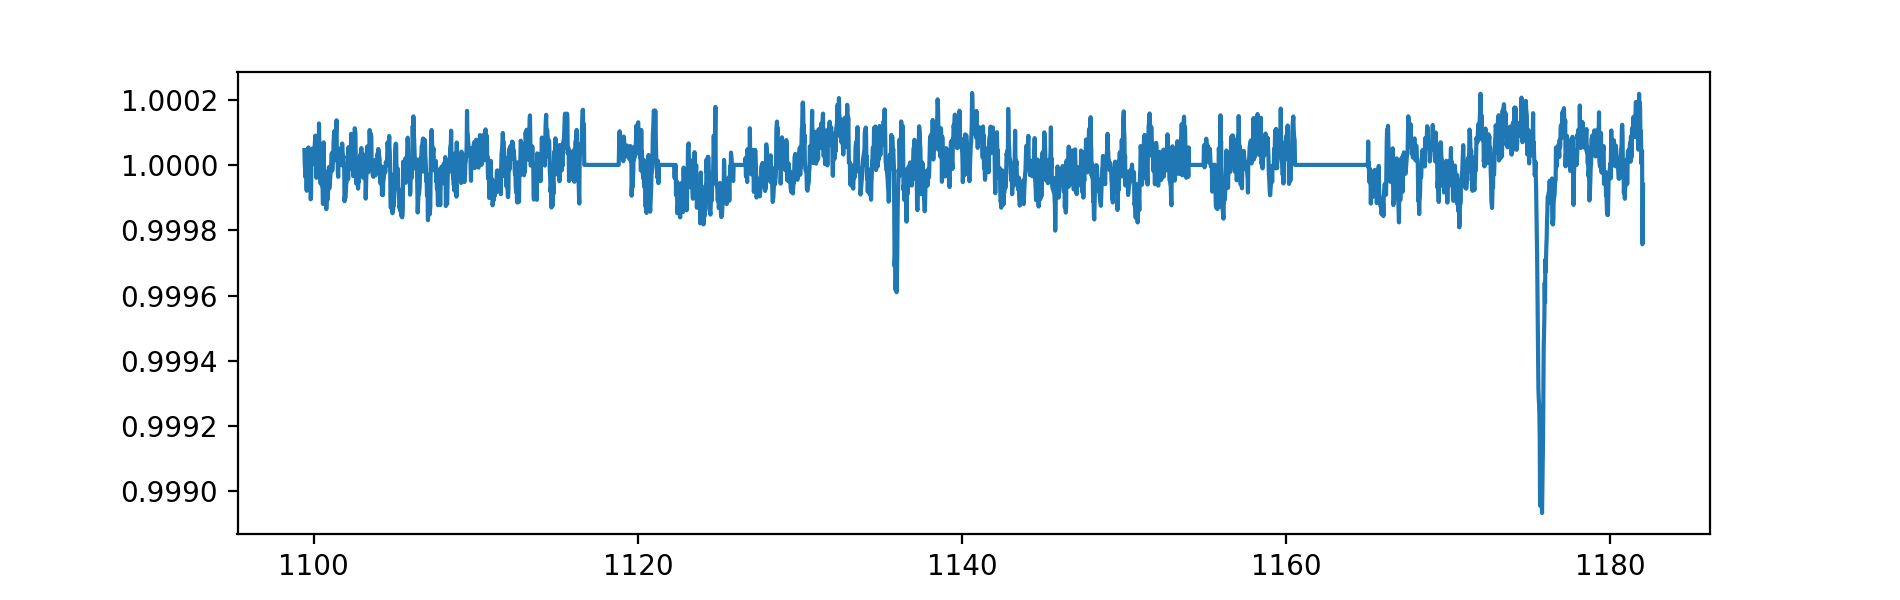

                col1                     col2         col3         col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- ---------- ----------- ------------
kplr011084727-2012004120508_llc.fits -38.30063629 -8.89771187 1076.07456386 1.79911672 0.12479382 0.33590656 0.40865912 -0.00096458 maybeTransit


<IPython.core.display.Javascript object>


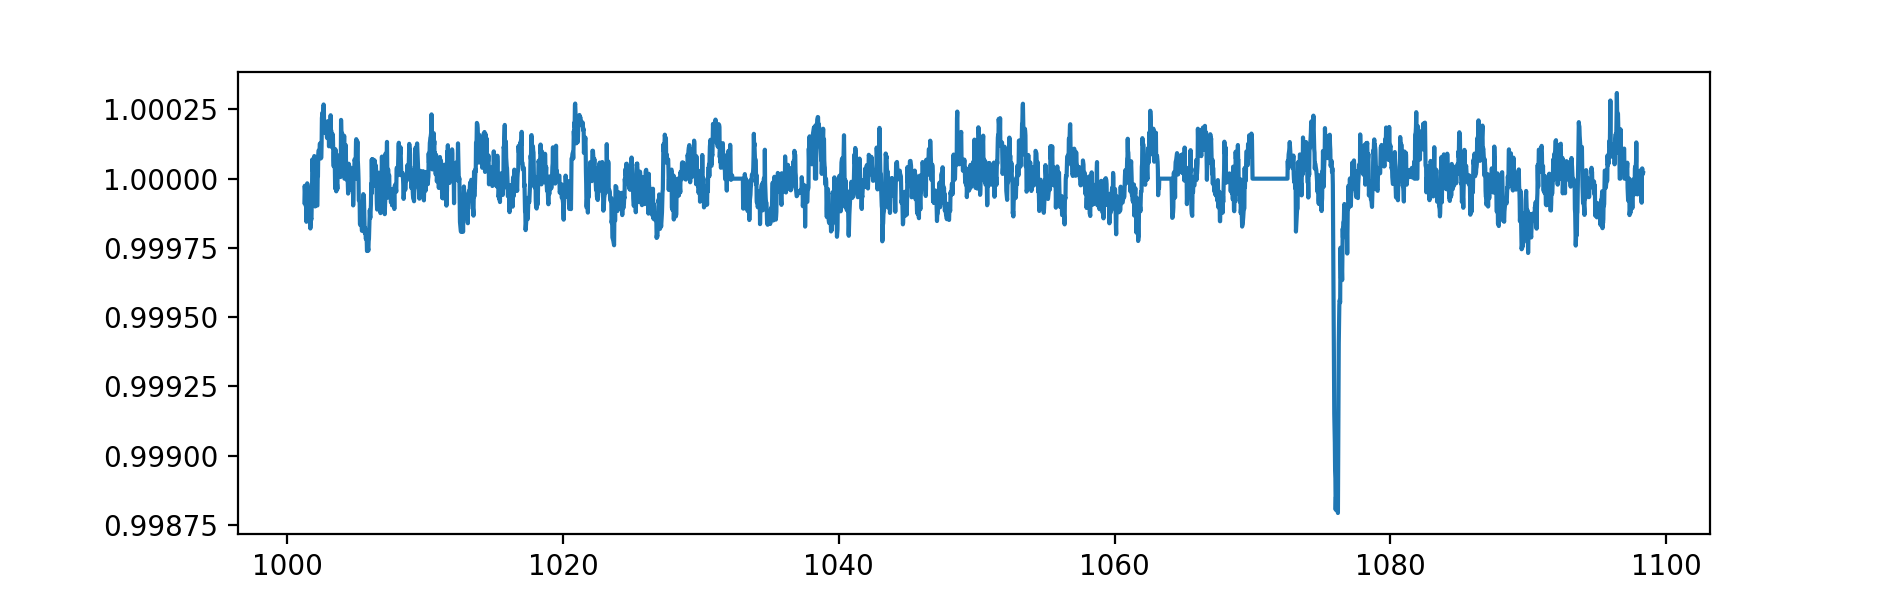

                col1                     col2       col3        col4        col5       col6      col7       col8        col9       col10    
------------------------------------ ----------- ---------- ------------ ---------- --------- ---------- ---------- ----------- ------------
kplr003542116-2011271113734_llc.fits -38.8303566 -8.3169875 991.85041874 1.07852255 0.2846358 0.25323462 0.61300998 -0.00074351 maybeTransit


<IPython.core.display.Javascript object>


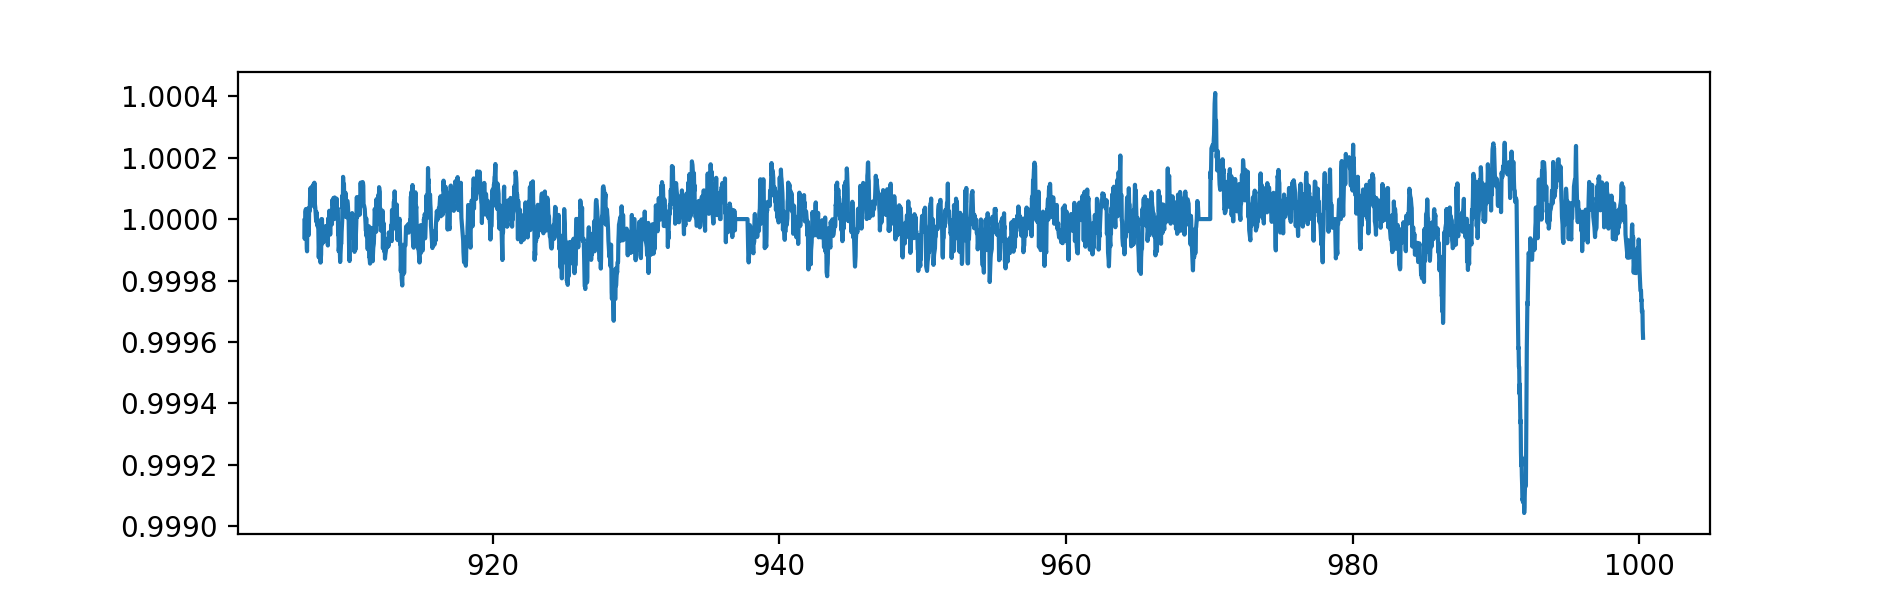

                col1                     col2         col3         col4        col5       col6      col7       col8        col9       col10    
------------------------------------ ------------ ------------ ------------ ---------- --------- ---------- ---------- ----------- ------------
kplr003542116-2012179063303_llc.fits -45.53715897 -11.06552227 1268.1733953 1.05270726 0.2423104 0.22613767 0.51086371 -0.00103507 maybeTransit


<IPython.core.display.Javascript object>


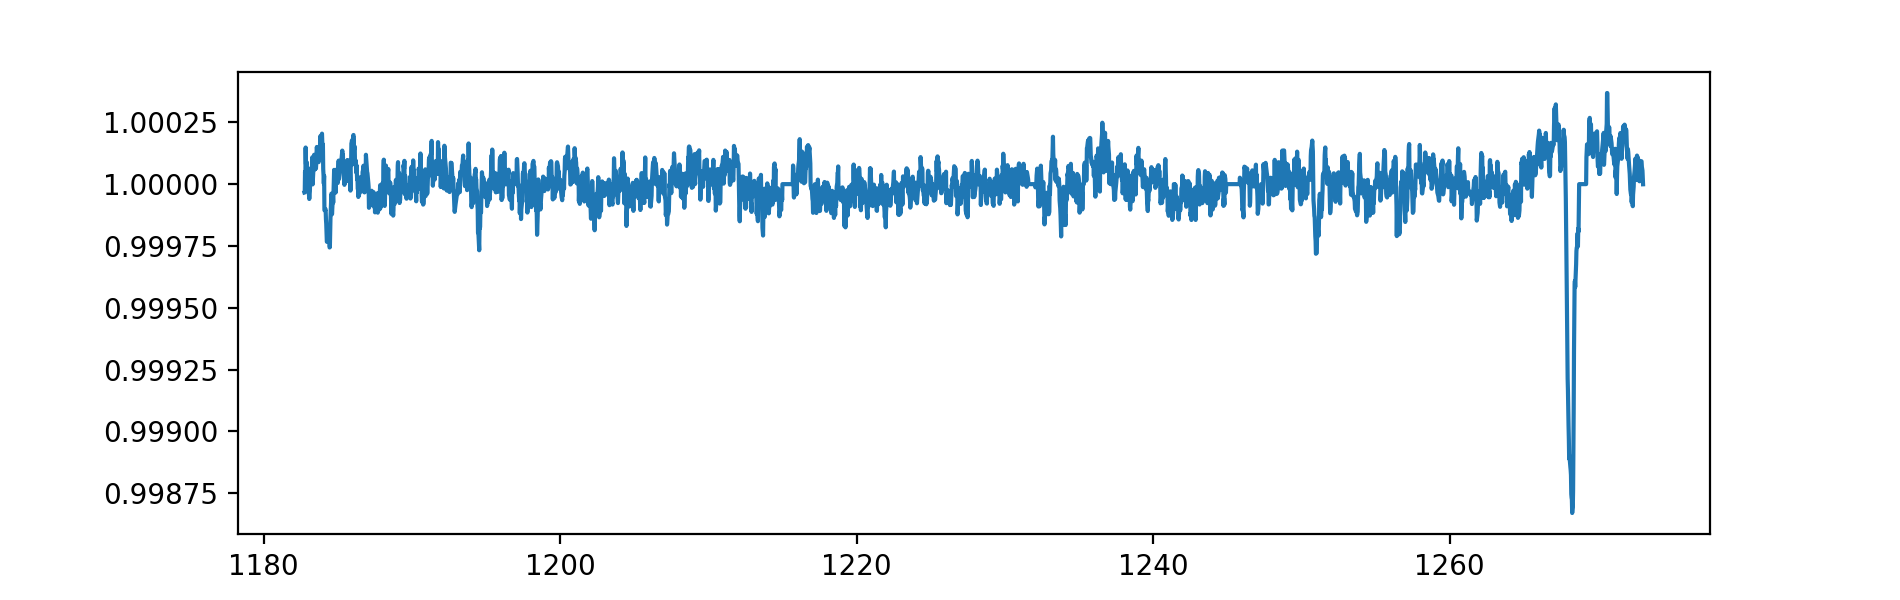

                col1                     col2         col3         col4        col5       col6       col7       col8       col9       col10    
------------------------------------ ------------ ----------- ------------- ---------- ---------- ---------- --------- ----------- ------------
kplr005622759-2013011073258_llc.fits -28.70291138 -7.17676774 1429.69880446 1.05393392 0.31543258 0.71864837 1.1238039 -0.00060736 maybeTransit
artefact
                col1                     col2         col3        col4        col5       col6       col7       col8        col9       col10    
------------------------------------ ------------ ----------- ------------ ---------- ---------- ---------- ---------- ----------- ------------
kplr008027456-2013011073258_llc.fits -25.68018913 -8.16443912 1448.9464936 1.11091925 0.23821708 0.49723678 0.85817934 -0.00035172 maybeTransit


<IPython.core.display.Javascript object>


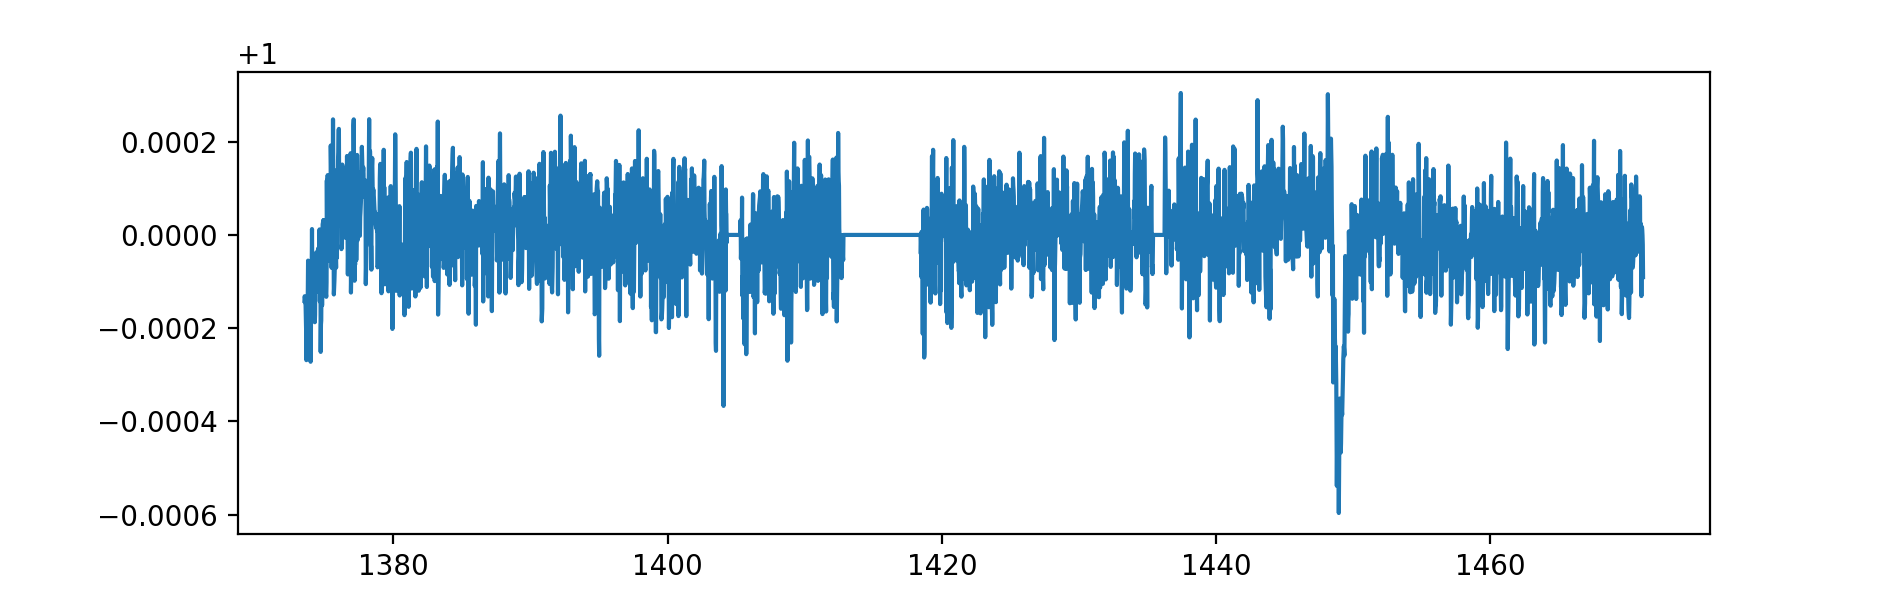

In [19]:
# take a look at full quarters with dips
for i,row in enumerate(data[ok]):
    print(row)
    kic_no = int(row['col1'].split('-')[0].split('kplr')[1])
    if kic_no in kic_artefacts:
        print('artefact')
    else:
        star = kic.star(kic_no)
        lcs = star.get_light_curves()
        i = np.where(tools.d2q(row['col4']) == np.array([l.sci_data_quarter for l in lcs]))[0][0]
        time, timestep, flux, flux_ls, quality, real = get_lc(lcs[i].filename,
                                                           drop_bad_points=True,
                                                           keep_interpolated=True)

        fig, ax = plt.subplots(figsize=(9.5,3), sharex=True)
        ax.plot(time, flux_ls+1.0, '-')

In [20]:
dr2 = Table.read('dr2.xml')

In [21]:
pl = Table.read('young-cl.xml')

<IPython.core.display.Javascript object>


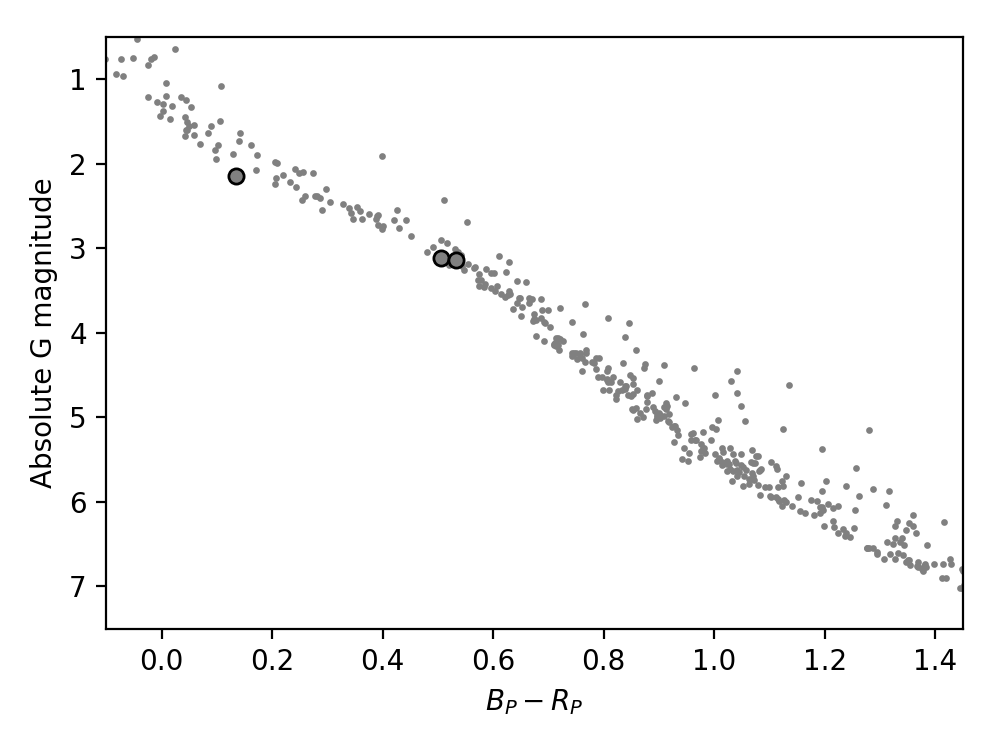

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [22]:
fig, ax = plt.subplots(figsize=(5,3.75))

# uncomment one of these
# ax.scatter(dr2['bp_rp'], dr2['phot_g_mean_mag'] - 5*(np.log10(1e3/dr2['parallax'])-1),
#            s=2, color='grey')
ax.scatter(pl['bp_rp'], pl['phot_g_mean_mag'] - 5*(np.log10(1e3/pl['parallax'])-1),
           s=2, color='grey')

for id1 in [2052852775308914176,2129671009876558336,2126145052183993344]:
    ok = dr2['source_id'] == id1
    ax.scatter(dr2[ok]['bp_rp'], dr2[ok]['phot_g_mean_mag'] - 5*(np.log10(1e3/dr2[ok]['parallax'])-1),
              color='grey', s=30, edgecolors='black')
    
ax.set_ylim(7.5,0.5)
ax.set_xlim(-0.1,1.45)
ax.set_xlabel('$B_P - R_P$')
ax.set_ylabel('Absolute G magnitude')

fig.tight_layout()
fig.savefig('figs/hr.pdf')